# WOE Visualization: Feature-Level and Prediction-Level

This notebook demonstrates the `visualize_woe` function for both:

1. **Feature-level visualization**: Showing WOE values for categories within a single feature
2. **Prediction-level visualization**: Showing feature contributions to a specific prediction

Both modes support probability (proba) and logit display.


In [1]:
import numpy as np
import pandas as pd

from fastwoe import FastWoe, WeightOfEvidence
from fastwoe.plots import visualize_woe

## Create Sample Data

We'll create a dataset with categorical features to demonstrate WOE visualization.


In [2]:
# Create sample data
n_samples = 1000

data = {
    "channel": np.random.choice(
        ["Online", "Branch", "Phone", "Mobile"], n_samples, p=[0.4, 0.3, 0.2, 0.1]
    ),
    "card_usage": np.random.choice(["< 50%", "50-80%", "> 80%"], n_samples, p=[0.3, 0.4, 0.3]),
    "region": np.random.choice(["North", "South", "East", "West"], n_samples),
    "product_type": np.random.choice(
        ["Standard", "Premium", "Basic"], n_samples, p=[0.5, 0.3, 0.2]
    ),
}

X = pd.DataFrame(data)

# Create target with some relationship to features
y = np.zeros(n_samples)
for i in range(n_samples):
    prob = 0.04  # Base default rate
    if X.iloc[i]["channel"] == "Online":
        prob += 0.05
    if X.iloc[i]["card_usage"] == "< 50%":
        prob -= 0.01
    if X.iloc[i]["region"] == "North":
        prob += 0.02
    y[i] = np.random.binomial(1, prob)

print(f"Dataset shape: {X.shape}")
print(f"Default rate: {y.mean():.2%}")
print("\nFeatures:")
print(X.head())

Dataset shape: (1000, 4)
Default rate: 6.10%

Features:
  channel card_usage region product_type
0  Online     50-80%   East     Standard
1  Online     50-80%   East     Standard
2  Mobile      < 50%   East        Basic
3  Online      > 80%  North     Standard
4  Online      < 50%  South     Standard


## Fit FastWoe Encoder


In [3]:
# Fit FastWoe encoder
encoder = FastWoe()
encoder.fit(X, y)

print("Encoder fitted successfully!")
print(f"Features encoded: {list(encoder.get_all_mappings().keys())}")

Encoder fitted successfully!
Features encoded: ['channel', 'card_usage', 'region', 'product_type']


## 1. Feature-Level Visualization

Visualize WOE values for individual features. This shows how different categories within a feature affect the target.

### Channel Feature (Probability/Proba Mode)


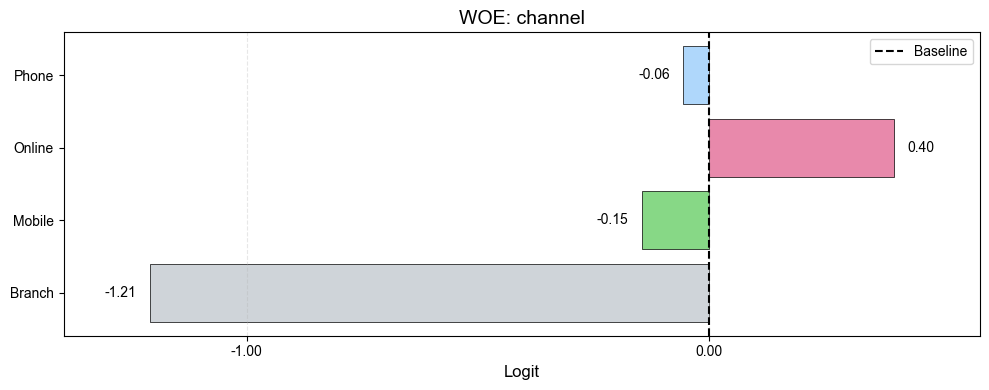


WOE Data:
  category       woe     logit  logit_delta
0   Branch -1.209580 -3.943522    -1.209580
1   Mobile -0.145257 -2.879198    -0.145257
2   Online  0.399373 -2.334568     0.399373
3    Phone -0.055549 -2.789491    -0.055549


In [4]:
# Visualize channel feature in probability mode
result = visualize_woe(
    encoder, feature_name="channel", mode="logit", figsize=(10, 4), show_plot=True
)

print("\nWOE Data:")
print(result)

### Card Usage Feature (Probability/Proba Mode)


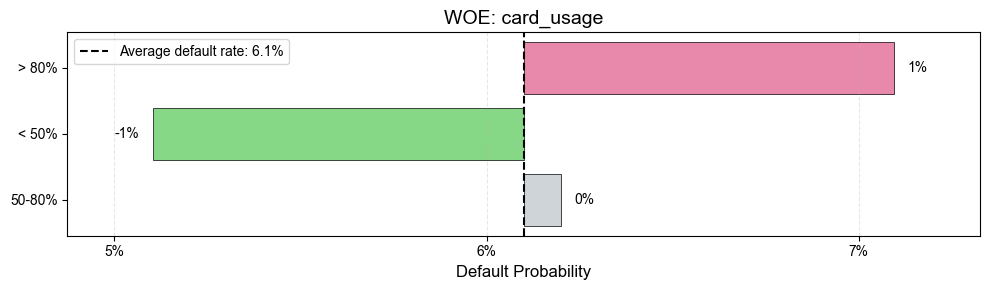


WOE Data:
  category       woe     proba  proba_delta
0   50-80%  0.017233  0.061995     0.000995
1    < 50% -0.188587  0.051051    -0.009949
2    > 80%  0.161693  0.070946     0.009946


In [5]:
# Visualize card_usage feature
result = visualize_woe(
    encoder, feature_name="card_usage", mode="proba", figsize=(10, 3), show_plot=True
)

print("\nWOE Data:")
print(result)

### Channel Feature (Logit Mode)


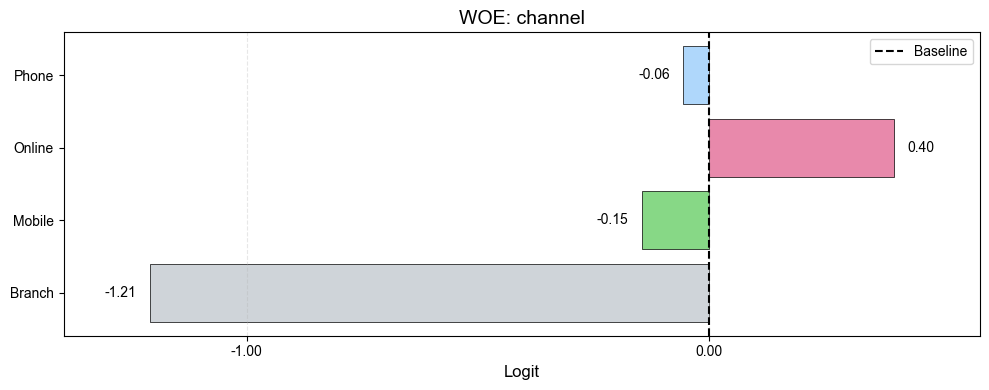


WOE Data:
  category       woe     logit  logit_delta
0   Branch -1.209580 -3.943522    -1.209580
1   Mobile -0.145257 -2.879198    -0.145257
2   Online  0.399373 -2.334568     0.399373
3    Phone -0.055549 -2.789491    -0.055549


In [6]:
# Visualize channel feature in logit mode
result = visualize_woe(
    encoder, feature_name="channel", mode="logit", figsize=(10, 4), show_plot=True
)

print("\nWOE Data:")
print(result)

## 2. Prediction-Level Visualization

Visualize feature contributions for a specific prediction. This shows how each feature contributes to the final prediction for a single sample.

### Create WeightOfEvidence Explainer


In [7]:
# Create explainer
explainer = WeightOfEvidence(encoder, X, y)

print("Explainer created successfully!")

Explainer created successfully!


### Get Explanation for a Sample


In [8]:
# Select a sample to explain
sample_idx = 0
sample = X.iloc[sample_idx]

print(f"Sample to explain (index {sample_idx}):")
print(sample)
print(f"\nTrue label: {y[sample_idx]}")

# Get explanation
explanation = explainer.explain(sample, return_dict=True)

print(f"\nPredicted label: {explanation['predicted_label']}")
print(f"Total WOE: {explanation['total_woe']:.3f}")
print(f"Interpretation: {explanation['interpretation']}")
print("\nFeature contributions:")
for feature, woe_val in explanation["feature_contributions"].items():
    print(f"  {feature}: {woe_val:.3f}")

Sample to explain (index 0):
channel           Online
card_usage        50-80%
region              East
product_type    Standard
Name: 0, dtype: object

True label: 0.0

Predicted label: Positive
Total WOE: 0.022
Interpretation: Weak evidence FOR the hypothesis

Feature contributions:
  channel: 0.399
  card_usage: 0.017
  region: -0.398
  product_type: 0.003


### Visualize Feature Contributions (Probability/Proba Mode)


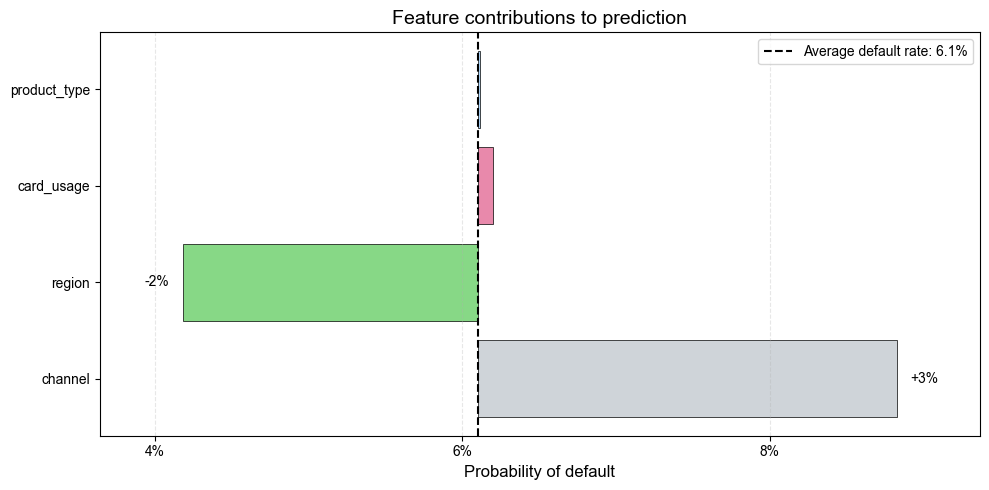


Feature Contribution Data:
        feature       woe     proba  proba_delta
0       channel  0.399373  0.088300     0.027300
2        region -0.397592  0.041825    -0.019175
1    card_usage  0.017233  0.061995     0.000995
3  product_type  0.002511  0.061144     0.000144


In [9]:
# Visualize feature contributions in probability mode
result = visualize_woe(
    encoder, explanation=explanation, mode="proba", figsize=(10, 5), show_plot=True
)

print("\nFeature Contribution Data:")
print(result)

### Visualize Feature Contributions (Logit Mode)


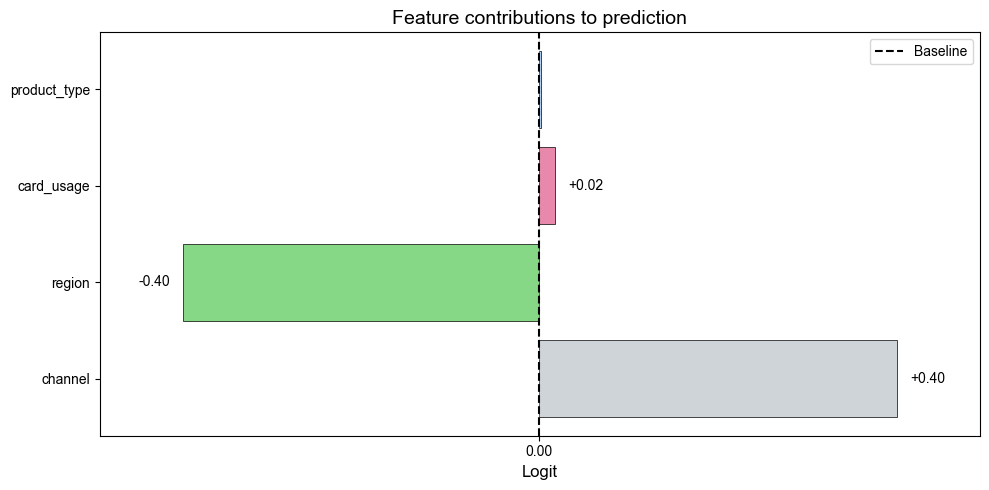


Feature Contribution Data:
        feature       woe     logit  logit_delta
0       channel  0.399373 -2.334568     0.399373
2        region -0.397592 -3.131534    -0.397592
1    card_usage  0.017233 -2.716708     0.017233
3  product_type  0.002511 -2.731431     0.002511


In [10]:
# Visualize feature contributions in logit mode
result = visualize_woe(
    encoder, explanation=explanation, mode="logit", figsize=(10, 5), show_plot=True
)

print("\nFeature Contribution Data:")
print(result)